In [1]:
from tqdm import tqdm
import json
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
import pytorch_lightning as pl
import os
import argparse

/root/miniconda3/envs/py36_LM/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd ..

/home/UNILM/summary-QA


In [3]:
from QA_longformer import QA, QA_F1, EM

In [4]:
os.environ['CUDA_VISIBLE_DEVICES']='1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
#parser = argparse.ArgumentParser()
#parser.add_argument('--learning_rate', default=5e-5, type=float)
#args = parser.parse_args()
args='a'
QA_model = QA(args)

Some weights of the model checkpoint at markussagen/xlm-roberta-longformer-base-4096 were not used when initializing XLMRobertaForQuestionAnswering: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.encoder.layer.0.attention.self.query_global.weight', 'roberta.encoder.layer.0.attention.self.query_global.bias', 'roberta.encoder.layer.0.attention.self.key_global.weight', 'roberta.encoder.layer.0.attention.self.key_global.bias', 'roberta.encoder.layer.0.attention.self.value_global.weight', 'roberta.encoder.layer.0.attention.self.value_global.bias', 'roberta.encoder.layer.1.attention.self.query_global.weight', 'roberta.encoder.layer.1.attention.self.query_global.bias', 'roberta.encoder.layer.1.attention.self.key_global.weight', 'roberta.encoder.layer.1.attention.self.key_global.bias', 'roberta.encoder.layer.1.attention.self.value_global.weight', 'roberta.encoder.l

In [6]:
#QA_model.load_state_dict(torch.load('./QA/Longformer_b16_lr5e-5/lightning_logs/version_1/checkpoints/last.ckpt')['state_dict'])
QA_model.load_state_dict(torch.load('./QA/Longformer_1cycle/lightning_logs/version_2/checkpoints/checkpoints_epoch=19.ckpt')['state_dict'])

<All keys matched successfully>

In [6]:
tokenizer = AutoTokenizer.from_pretrained('markussagen/xlm-roberta-longformer-base-4096', max_length = 4096, padding ='max_length', truncation=True)

In [9]:
# path = '../../UNILM_/data/KLUE/klue_benchmark/klue-mrc-v1.1/klue-mrc-v1.1_dev.json'
path = '1cycle_2/QA_convert2.json'
#path ='./klue-mrc-v1.1_train_pre.json'
with open(path, 'r') as fr:
    QA_json = json.load(fr)
print('num_data:',len(QA_json))

num_data: 14027


In [9]:
val_ratio = 0.95
train_len = int(len(QA_json)*val_ratio)
QA_train = QA_json[:train_len]
QA_valid = QA_json[train_len:]

In [49]:
s_list=[]
e_list=[]

In [64]:
idx =16
for idx in range(0,40):#1903,len(jdata['data'])):
    #print(idx)
    elem = QA_valid[idx]
    context = elem['context']
    que = elem['question']
    
    ans = context[elem['start']:elem['end']]
    
    print('question:',que)
    print('answer:',ans)

    inputs = tokenizer(context, que, return_tensors='pt',
                       truncation=True,
                       max_length=1024,
                       padding='max_length',
                       add_special_tokens=True)
    QA_model.model.eval()
    with torch.no_grad():
        result = QA_model.model(**inputs)
        start_idx = result.start_logits.argmax()
        end_idx = result.end_logits.argmax()
        s_list.append(start_idx)
        e_list.append(end_idx)
        print(start_idx.item(), end_idx.item())
        predict_answer_tokens=inputs.input_ids[0,start_idx:end_idx+1]
        print('predict:',tokenizer.decode(predict_answer_tokens))
        print('------------')

question: 산가 계산식은?
answer: \( =5.611 \times(\mathrm{a}-\mathrm{b}) \)
1007 509
predict: 
------------
question: 2형 당뇨병은 당뇨병 환자 중 비율이 얼마나 돼?
answer: \( 95 \% \) 이상
92 97
predict: 인슐린 저항성
------------
question: 2형 당뇨병이 발병하는 대표적 원인은 뭐야?
answer: 인슐린 저항성
92 97
predict: 인슐린 저항성
------------
question: \( \operatorname{PPAR} \gamma \) 작용제의 부작용이 아닌 것은 뭐지?
answer: 인슐린 저항성을 개선
897 431
predict: 
------------
question: 삼색싸리는 무엇을 억제해?
answer: tyrosinase
662 156
predict: 
------------
question: 실험에 사용된 삼색싸리는 어디서 얻었어?
answer: 해남 달마산
128 673
predict: insulin receptor substrate (IRS) \( 1 \cdot 2 \) tyrosine 잔기의 인산화가 증가되고, 하위신호전달인 phosphoinositide3-kinases (PI3K)/protein kinase B (AKT)의 활성화를 통하여 당 수송체 단백질인 glucose transporter type (GLUT) 4가 세포 내 원형질에서 세포막으로 이동하여 포도당을 유입하는 과정이 감소된다는 것을 의미한다. 또 다른 원인은 췌장의 베타세포 기능 저하와 관련된 인슐린 분비능의 저하가 주된 원인으로 알려져 있다. 이러한 2형 당뇨병의 치료약물로는 경구용 혈당강하제나 인슐린 저항성을 개선하는 metformin과 peroxisome proliferator-activated receptor \( \operatorname{(PPAR)} \gamma \) 작용제로 알 려진 thia-zolidinedi

### f1-score, EM 계산

In [12]:
%load_ext autoreload
%autoreload 2
from QA_longformer import QA_dataset, QA_F1, EM
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
QA_train[0]

{'context': '<h1>제\\(1\\)장 쌍곡 기하학</h1><p>역사적으로 유클리드 기하학의 평행공준 \\( \\mathrm{V} \\)(힐베르트의 평행공리)를 다른 공리군을 사용하여 명하고자 시도한 것이 비유클리드 기하학의 연구의 발단이었다. 평행공리를 부정했을 때 다른 공리군들이 서로 모순 없이 성립하는 기하학 모형을 제시함으로써 평행공리가 다른 공리군들로부터 독립적이라는 것을 알게 되었다. 이러한 기하학은 유를리드 기하학이 아닌 비유클리드 기하학이다.</p><h2>1.1 평행공리</h2><p>유클리드 평행공준 \\( \\mathrm{V} \\)는 다음 힐베르트의 평행공리와 동치이다.</p><p>힐베르트 평행공리: 직선 \\( l \\)과 \\( l \\) 위에 있지 않는 점 \\( P \\)가 주어질 때, 점 \\( P \\)를 지나면서 \\( l \\)과 만나지 않는 직선 \\( m \\)은 유일하게 존재한다.</p><p>힐베르트의 평행공리의 부정명제는 다음 두 공리 중 하나이다.</p><p>타원공리(elliptic axiom): 직선 \\( l \\)과 \\( l \\) 위에 있지 않는 점 \\( P \\)가 주어질 때, 점 \\( P \\)를 지나면서 \\( l \\)과 만나지 않는 직선 \\( m \\)은 존재하지 않는다.</p><p>쌍곡공리(hyperbolic axiom): 직선 \\( l \\)과 \\( l \\) 위에 있지 않는 점 \\( P \\)가 주어질 때, 점 \\( P \\)를 지나면서 \\( l \\)과 만나지 않는 직선 \\( m \\)은 \\( 2 \\)개 이상 존재한다.</p><p>유클리드 평행공준 \\( \\mathrm{V} \\)를 부정하여 타원공리를 선택한 기하학을 타원기하학(elliptic geometry)이라 하고, 쌍곡공리를 선택한 기하학을 쌍곡기하학(hyperbolic geometry)이라 한다.</p><h2>1.2 쌍곡기하학의 모형</h2><p>\\((1)\\) 클라인 모형</p><p>유클리드 평면 안에

In [115]:
ed_token_idx_list = []
for data in tqdm(QA_json):
    context = data['context']
    inputs = tokenizer(context, data['question'],
                            return_tensors="pt",
                            add_special_tokens=True)
    target = inputs["input_ids"].squeeze()
    if data['start'] == -1:
        st_idx = 0
    else:
        st_idx = data['start']
    ed_idx = data['end']

    lst = tokenizer.tokenize(data['context'])
    before = context[:st_idx]
    ans = context[st_idx:ed_idx]
    before_token = tokenizer.tokenize(before)
    ans_token = tokenizer.tokenize(ans)
    
    ed_token_idx = len(before_token)+len(ans_token)
    ed_token_idx_list.append({'ed_token_idx':ed_token_idx,
                              'context_len':len(target),
                             })

100%|██████████| 14027/14027 [01:19<00:00, 177.55it/s]


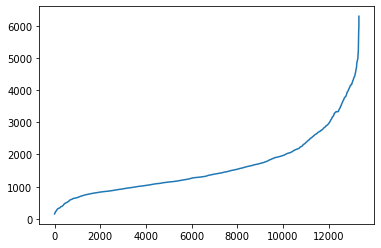

In [100]:
import matplotlib.pyplot as plt
len_list.sort()
plt.plot(len_list)
plt.show()

In [118]:
aa = [i for i, e in enumerate(ed_token_idx_list) if e['ed_token_idx']>=4096]

In [122]:
filtered_json = [e for i, e in enumerate(QA_json) if i not in aa]

In [123]:
len(filtered_json)

14014

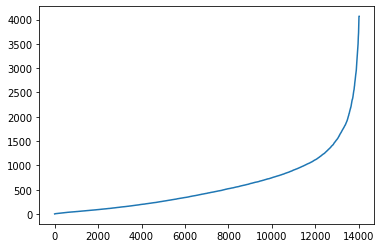

In [128]:
ed_list2 = [e['ed_token_idx'] for i, e in enumerate(ed_token_idx_list) if e['ed_token_idx']<4096]
ed_list2.sort()
plt.plot(ed_list2)
plt.show()

In [8]:
from QA_longformer import filter_data

In [11]:
new_json = filter_data(QA_json, tokenizer, 2048)

100%|██████████| 14027/14027 [00:48<00:00, 290.93it/s]


In [13]:
len(new_json), len(QA_json)

(13543, 14027)

In [15]:
with open('1cycle_2/QA_convert2048.json','w') as f:
    json.dump(new_json,f)

In [64]:
QA_valid_dataset = QA_dataset(QA_valid, tokenizer, 4096)
QA_valid_dataloader = DataLoader(QA_valid_dataset, batch_size=1, shuffle=False)

In [95]:
my_list = []
QA_model.model.eval()
QA_model.model.to(device)
with torch.no_grad():
    for val_batch in tqdm(QA_valid_dataloader):
        target, attention_mask, start, end = val_batch
        target = target.to(device)
        attention_mask = attention_mask.to(device)
        start = start.to(device)
        end = end.to(device)
        outputs = QA_model.model(input_ids = target, attention_mask = attention_mask, start_positions=start, end_positions=end)
        pred_st = outputs.start_logits.argmax()
        pred_end = outputs.end_logits.argmax() + 1
        pred = target[0][pred_st:pred_end].detach().tolist()
        truth = target[0][start:end].detach().tolist()
        pred_txt = tokenizer.decode(pred)
        truth_txt = tokenizer.decode(truth)
        em = EM(truth, pred)
        f1 = QA_F1(truth, pred)
        my_list.append({'pred_txt':pred_txt,'truth_txt':truth_txt,
                        'em': em ,'f1':f1,
                        'pred':pred,'truth':truth
                       })

 39%|███▊      | 272/702 [00:20<00:31, 13.59it/s]


KeyboardInterrupt: 

In [ ]:
my_list[15]

In [98]:
len(QA_valid_dataset[15][0])

4096

In [87]:
QA_valid_dataset[15][0]

(tensor([   0, 4426,  127,  ...,    1,    1,    1]),
 tensor([1, 1, 1,  ..., 0, 0, 0]),
 tensor(1109),
 tensor(1112))

In [88]:
QA_valid_dataset[15][0][1109:1112]

tensor([ 8354, 25354, 12322])

In [92]:
tokenizer.decode(QA_valid_dataset[17][0][1109:1112])

'Korea), 항'

In [79]:
len(tokenizer.tokenize('동결건조'))

4

In [81]:
QA_valid[15]

{'context': '<h2>시료제조</h2><p>시료 제조에 사용된 천마는 천마(GR0)와 증숙 천마로 구분 하였고, 증숙 천마는 \\(1\\)증(GR\\(1\\)), \\(3\\)증(GR\\(3\\)), \\(6\\)증(GR\\(6\\)), \\(9\\)증(GR\\(9\\)) 천마까지 제조하였다.</p><p>천마는 세척 후 일정 크기로 절단하여 건조기에서 건조하였고, 증숙 천마는 \\(1\\)증부터 \\(9\\)증까지 일정한 시간동안 증숙하였고, 증숙 후 건조하여 증숙 횟수를 반복하였다. 증숙은 무압식 스팀증숙기를 사용하여 증숙온도 \\( 90^{\\circ} \\mathrm{C} \\) 에서 \\(2\\)시간씩 물로 증숙하였고, 건조는 밀폐제습식 건조기를 사용하여 수분함량 \\( 15 \\% \\) 미만으로 \\(4\\)시간 동안 건조하였다. 천마의 발효에 사용된 균주는 Lactobacillus plantarum (F\\(1\\)), Leuconostoc mesenteroides (F\\(2\\)), Streptococcus thermophilus (F\\(3\\)), Saccharomyces cerevisiae (F\\(4\\))로 대전대학교 미생명생물공학과 이찬용 교수로부터 받아 사용하였다. 발효 천마의 항산화 활성 및 성분 분석을 위한 시료는 액상발효를 시행하였다. 사각 투명 밀폐용기에 각각 라벨을 붙이고, 시료를 각각 \\( 5 \\mathrm{~g} \\) 씩 넣은 후, \\( 45 \\mathrm{~mL} \\) 의 멸균 증류수를 첨가하여 현탁하였다 \\( (10 \\% \\mathrm{w} / \\mathrm{v}) \\). 시료가 포함된 용기마다 미리 혼합된 복합효소액 \\( 0.5 \\mathrm{~mL} \\) 를 첨가하고 \\(24\\) 시간 반응시켰다. 시료에 따라 정해진 균주 현탁액을 \\( 0.5 \\mathrm{~mL} \\) 씩 접종하여 섭씨 \\( 35^{\\circ} \\mathrm{C} \\) 인큐베이터에서 정치 배양하